In [888]:
#@title The MIT License (MIT)
#
# Copyright (c) 2025 Eric dos Santos.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

# Estudo de caso: agrupamento de espécies de plantas com base em características biológicas

Este estudo investiga o agrupamento de espécies de flores com base em suas características biológicas, utilizando técnicas de aprendizado não supervisionado. Exploramos os dados, aplicamos pré-processamento e utilizamos algoritmos como **PCA** e **K-Means** para identificar padrões e estruturar os clusters.

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ericshantos/ML-exercise/blob/main/clustering/specie_flowers/clustering_specie_flowers.ipynb
"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Rode no Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ericshantos/ML-exercise/blob/main/clustering/specie_flowers/clustering_specie_flowers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Visualize o código no GitHub</a>
  </td>
</table>

## Carregamento de dados

In [ ]:
import kagglehub
import pandas as pd

In [891]:
# Read the file as a DataFrame
file_path = kagglehub.dataset_download("arshid/iris-flower-dataset", "IRIS.csv")

print("Path to dataset files:", file_path)

Path to dataset files: /root/.cache/kagglehub/datasets/arshid/iris-flower-dataset/versions/1/IRIS.csv


In [892]:
df = pd.read_csv(file_path)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Análise Exploratória de Dados (AED)


In [893]:
import seaborn as sns
import matplotlib.pyplot as plt

In [894]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


- **Obter as estatísticas descritivas:**

In [895]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [896]:
df["species"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

- **Visualização univariadas:**

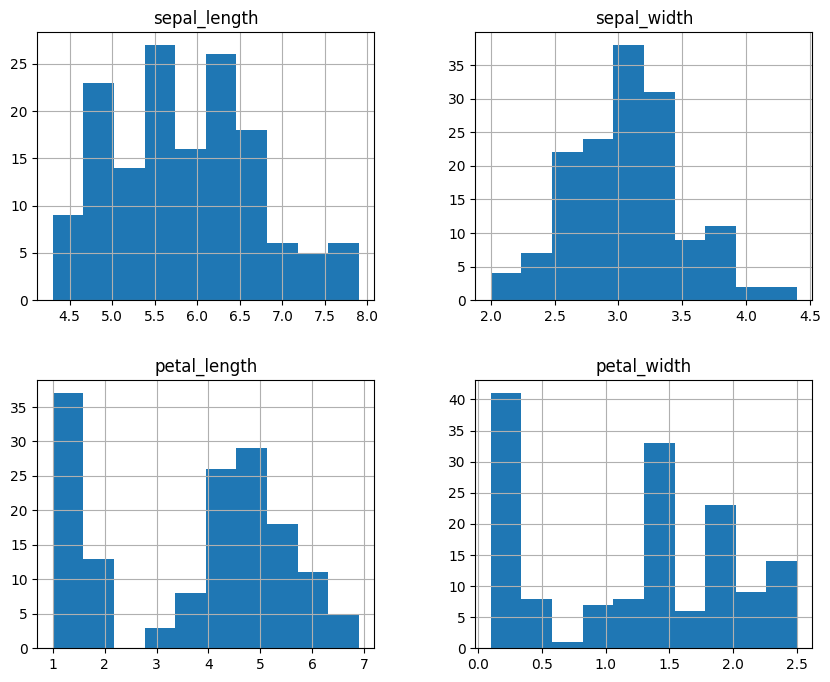

In [897]:
df.hist(figsize=(10,8))
plt.show()

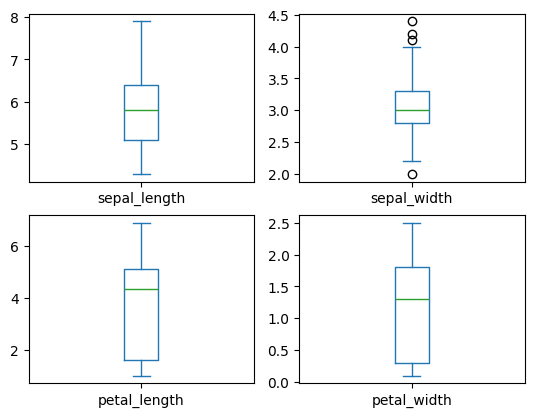

In [898]:
df.plot(kind='box', subplots=True, layout=(2,2))
plt.show()

- **Visualização bivariadas:**

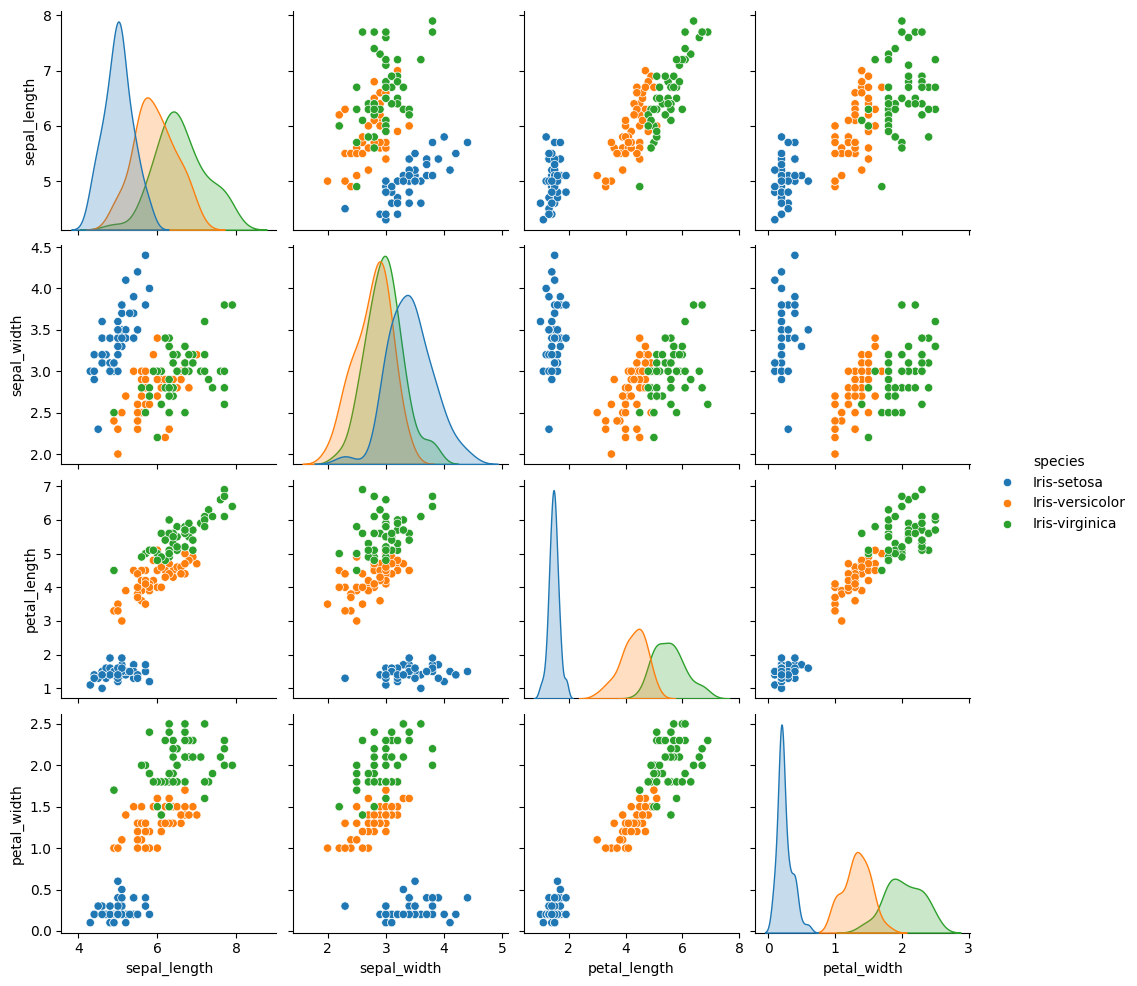

In [899]:
sns.pairplot(df, hue='species')
plt.show()

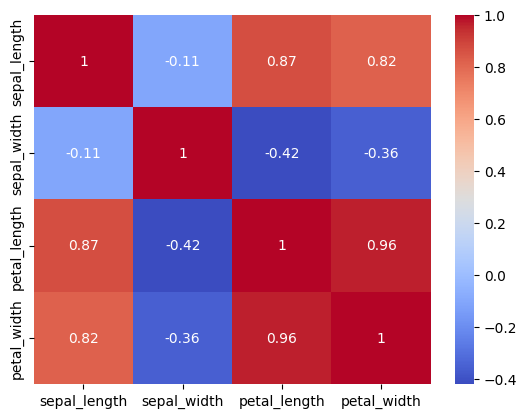

In [900]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### Percepções geradas

1. **Distribuições das variáveis**:
   - O **comprimento da sépala** (Sepal Length) tem uma distribuição normal, concentrada entre 5 e 7 cm.
   - A **largura da sépala** (Sepal Width) é concentrada em torno de 3 cm, com alguns outliers.
   - O **comprimento da pétala** (Petal Length) mostra dois grupos: curto (~1,5 cm) e longo (4-6 cm).
   - A **largura da pétala** (Petal Width) apresenta dois grupos: estreito (~0,2 cm) e largo (1-2 cm).

2. **Boxplots**:
   - As distribuições são amplamente centradas em torno da mediana, com algumas variáveis como a largura da sépala apresentando outliers.
   - O **comprimento da pétala** tem maior dispersão, sugerindo maior variabilidade nas flores.

3. **Correlação entre variáveis**:
   - Forte correlação entre **comprimento e largura das pétalas** (0,96).
   - **Comprimento da sépala** e **comprimento da pétala** também apresentam forte correlação (0,87).
   - **Largura da sépala** tem uma correlação negativa fraca com **comprimento da pétala** (-0,42).

4. **Pairplot e separação das espécies**:
   - **Iris-setosa** é facilmente separada das outras duas espécies, principalmente pelas variáveis de pétala.
   - **Iris-versicolor** e **Iris-virginica** têm alguma sobreposição, mas ainda podem ser diferenciadas.

5. **Insights principais**:
   - **Pétalas** são a chave para diferenciar as espécies.
   - **Comprimento da sépala** e **largura da sépala** são menos eficazes para separação.
   - As correlações indicam que **largura das pétalas** e **comprimento das pétalas** têm uma relação muito forte.

## Pré-processamento de dados

In [901]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import numpy as np

In [902]:
df_preprocessed = df.drop('species', axis=1).copy()

- Normalizando os dados

In [903]:
df_normalized = MinMaxScaler().fit_transform(df_preprocessed)

- Removendo outliers

In [904]:
df_without_outliers = df_normalized[(np.abs(zscore(df_normalized)) < 3).all(axis=1)]

## Clusterização

In [905]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [906]:
# Variáveis alvo
X = df_normalized

### Aplicação do PCA

In [907]:
from sklearn.decomposition import PCA

- Avaliando o número de `Componentes Principais`

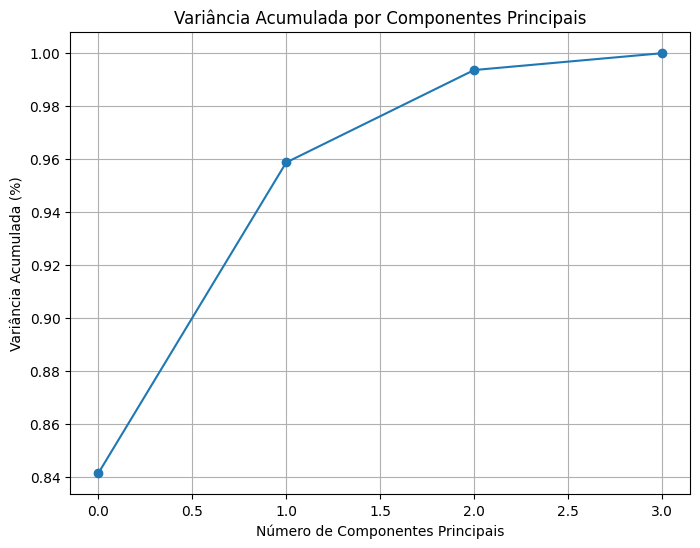

In [908]:
#Ajuste do PCA ao conjunto de dados
pca = PCA().fit(X)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Variância acumulada
cumulative_variance = explained_variance.cumsum()

# Plot da variância explicada
plt.figure(figsize=(8,6))
plt.plot(cumulative_variance, marker='o')
plt.title('Variância Acumulada por Componentes Principais')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada (%)')
plt.grid(True)
plt.show()

- Aplicando o PCA

In [909]:
# Ajuste do PCA
pca = PCA(n_components=2)

# Redução da dimencionadade do conjunto de dados
X_pca = pca.fit_transform(X)

### Visualização real dos dados

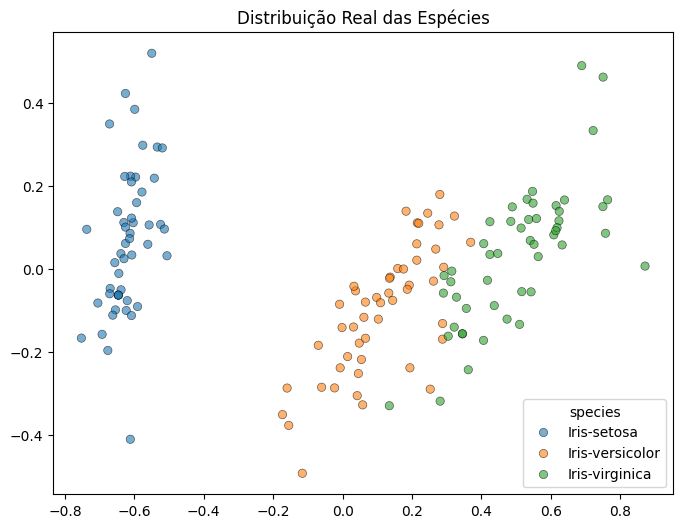

In [910]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['species'], palette='tab10', alpha=0.6, edgecolor='k')
plt.title("Distribuição Real das Espécies")
plt.show()

### Método do Cotovelo

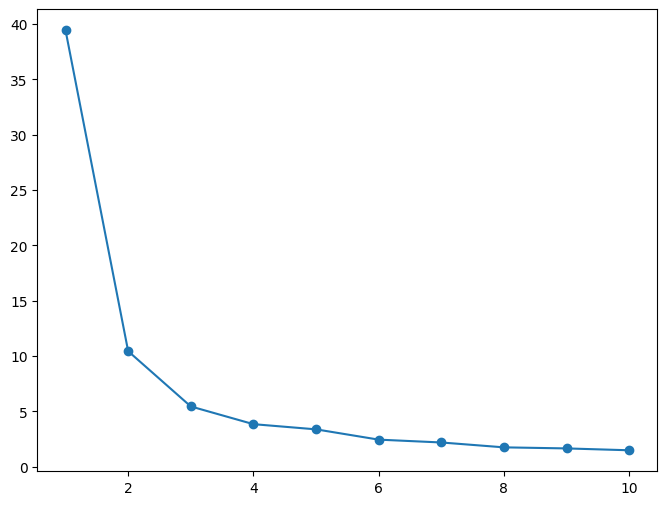

In [911]:
inertia =[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(1, 11), inertia, marker='o')

### Aplicando o K-means

In [912]:
# Definir o número de clusters
k_means = KMeans(n_clusters=3, init='random', random_state=42)

- Ajustando os dados do modelo

In [913]:
# Ajustando o modelo KMeans com os dados sem outliers
k_means.fit(df_without_outliers)

KMeans(init='random', n_clusters=3, random_state=42)

In [914]:
# Obter os centróides dos clusters
centroids = pca.transform(k_means.cluster_centers_)

# Obter as etiquetas de cada ponto no conjunto de dados completo
labels = k_means.predict(df_normalized)

# Adicionar os clusters ao DataFrame
df['cluster'] = labels

In [915]:
# Nº de cluster gerados
print(f'cluster gerados: ' + str(df['cluster'].unique()) + '\n')

# Primeiros 5 dados
df.head()

cluster gerados: [0 2 1]



,sepal_length,sepal_width,petal_length,petal_width,species,cluster
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


### Visualização dos resultados

In [944]:
species = df['species'].unique()

In [945]:
custom_label = [species[idx] for _, idx in enumerate(labels)]

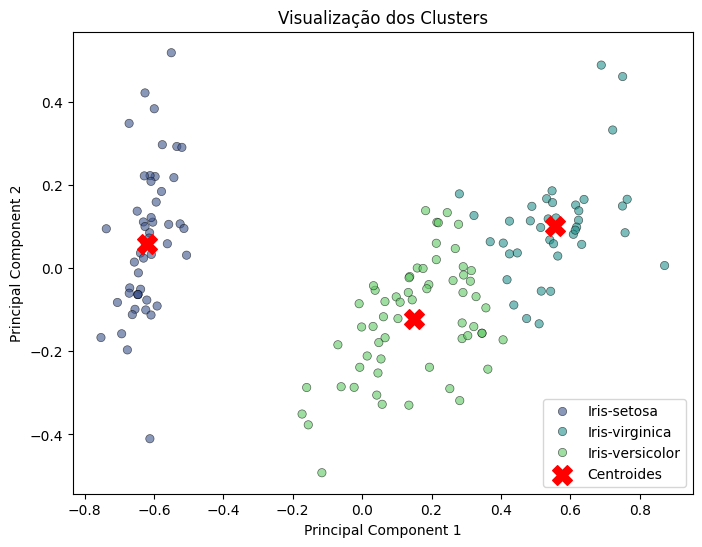

In [946]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=custom_label, palette='viridis', alpha=0.6, edgecolor='k')

# Destacar os centróides dos clusters
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')

# Configurações do gráfico
plt.title("Visualização dos Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

### Avaliação

In [918]:
# Avaliação - Índice de Silhueta
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Índice médio da Silhueta: {silhouette_avg:.4f}")

Índice médio da Silhueta: 0.5652
